In [2]:

import umap
import torch
import numpy as np
import matplotlib.pyplot as plt
from cebra import CEBRA
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.cross_decomposition import PLSRegression

if torch.cuda.is_available():
    DEVICE = "cuda"
else:
    DEVICE = "cpu"

## Modular (modulation range)

In [3]:
cebra_params = {
    'model_architecture': "offset10-model",
    'batch_size': 128,
    'temperature_mode': "auto",
    'distance': "cosine",
    'learning_rate': 0.01,
    'max_iterations': 10000,
    'time_offsets': 10,
    'output_dimension': 3,
    'device': "cuda_if_available",
    'verbose': True
    # Add more parameters as needed
}

In [4]:
# Define parameters
num_cells = 100  # Number of cells
num_trials = 500  # Number of trials
num_behaviors = 5  # Number of different behaviors


# Generate synthetic spiking data
np.random.seed(42)  # For reproducibility
spike_data = np.random.poisson(lam=0.5, size=(num_cells, num_trials))

# Function to generate labels and modulate spike data
def generate_labels_and_modulate_spikes(num_trials, num_behaviors, spike_data):
    labels = np.random.choice(num_behaviors, num_trials)
    for behavior in range(num_behaviors):
        modulation_factor = np.random.uniform(0.1, 1.1, size=(num_cells, 1))
        spike_data[:, labels == behavior] = spike_data[:, labels == behavior].astype(np.float64) * modulation_factor
    return labels

# Generate labels and modulate spike data
labels = generate_labels_and_modulate_spikes(num_trials, num_behaviors, spike_data)

# Split dataset into features (X) and labels (Y)
X = spike_data.T  # Transpose to get shape (num_trials, num_cells)
Y = labels

In [5]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [6]:
# Dimensionality reduction (example using PCA and t-SNE)
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_train)
X_pca_test = pca.transform(X_test)

umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=3)
X_umap = umap_model.fit_transform(X_train,y=y_train)
X_umap_test = umap_model.transform(X_test)

cebra_model = CEBRA(**cebra_params)
cebra_model.fit(X_train, y_train)
X_cebra = cebra_model.transform(X_train)
X_cebra_test = cebra_model.transform(X_test)

# aply LDA to the data
lda = LDA(n_components=3)
X_lda = lda.fit_transform(X_train, y_train)
X_lda_test = lda.transform(X_test)

pos: -9.9327 neg:  13.2304 total:  3.2977 temperature:  0.1000: 100%|██████████| 10000/10000 [02:14<00:00, 74.43it/s]


In [7]:
# Initialize and train kNN model
knn_pca = KNeighborsClassifier(n_neighbors=5)
knn_pca.fit(X_cebra, y_train)

# Make predictions and evaluate model performance
pca_accuracy = knn_pca.score(X_pca_test, y_test)
print(f'PCA Accuracy: {pca_accuracy:.2f}')

# Initialize and train UMAP model
umap_model = KNeighborsClassifier(n_neighbors=5)
umap_model.fit(X_umap, y_train)

# Make predictions and evaluate model performance
umap_accuracy = umap_model.score(X_umap_test, y_test)
print(f'UMAP Accuracy: {umap_accuracy:.2f}')

# Initialize and train CEBRA model
cebra_model = KNeighborsClassifier(n_neighbors=5)
cebra_model.fit(X_cebra, y_train)

# Make predictions and evaluate model performance
cebra_accuracy = cebra_model.score(X_cebra_test, y_test)
print(f'CEBRA Accuracy: {cebra_accuracy:.2f}')

# Initialize and train LDA model
lda_model = KNeighborsClassifier(n_neighbors=5)
lda_model.fit(X_lda, y_train)

# Make predictions and evaluate model performance
lda_accuracy = lda_model.score(X_lda_test, y_test)
print(f'LDA Accuracy: {lda_accuracy:.2f}')



PCA Accuracy: 0.12
UMAP Accuracy: 0.75
CEBRA Accuracy: 0.80
LDA Accuracy: 0.77


## Modular (modulation factor)

In [3]:
cebra_params = {
    'model_architecture': "offset10-model",
    'batch_size': 128,
    'temperature_mode': "auto",
    'distance': "cosine",
    'learning_rate': 0.01,
    'max_iterations': 10000,
    'time_offsets': 10,
    'output_dimension': 3,
    'device': "cuda_if_available",
    'verbose': True
    # Add more parameters as needed
}

In [4]:
# Define parameters
num_cells = 100  # Number of cells
num_trials = 500  # Number of trials
num_behaviors = 5  # Number of different behaviors

# Define modulation factor
modulation_factor = -0.2  # 0.5 = 50% modulation

# Generate synthetic spiking data
np.random.seed(42)  # For reproducibility
spike_data = np.random.poisson(lam=0.5, size=(num_cells, num_trials))

# Function to generate labels and modulate spike data
def generate_labels_and_modulate_spikes(num_trials, num_behaviors, spike_data, modulation_factor):
    num_cells = spike_data.shape[0]
    labels = np.random.choice(num_behaviors, num_trials)

    # Determine the number of units to modulate based on the absolute value of modulation_factor
    num_modulated_units = int(abs(modulation_factor) * num_cells)

    for behavior in range(num_behaviors):
        # Randomly select units to modulate
        modulated_units = np.random.choice(num_cells, num_modulated_units, replace=False)

        # Apply modulation
        for unit in modulated_units:
            if modulation_factor > 0:
                # Positive modulation
                spike_data[unit, labels == behavior] = spike_data[unit, labels == behavior].astype(np.float64) * np.random.uniform(1, 2)
            else:
                # Negative modulation
                spike_data[unit, labels == behavior] = spike_data[unit, labels == behavior].astype(np.float64) * np.random.uniform(0, 1)

    return labels

# Generate labels and modulate spike data
labels = generate_labels_and_modulate_spikes(num_trials, num_behaviors, spike_data, modulation_factor)

# Split dataset into features (X) and labels (Y)
X = spike_data.T  # Transpose to get shape (num_trials, num_cells)
Y = labels

In [5]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [6]:
# Train the models
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_train,y=y_train)
X_pca_test = pca.transform(X_test)

umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=3)
X_umap = umap_model.fit_transform(X_train,y=y_train)
X_umap_test = umap_model.transform(X_test)

cebra_model = CEBRA(**cebra_params)
cebra_model.fit(X_train, y_train)
X_cebra = cebra_model.transform(X_train)
X_cebra_test = cebra_model.transform(X_test)

lda = LDA(n_components=3)
X_lda = lda.fit_transform(X_train, y_train)
X_lda_test = lda.transform(X_test)

pos: -9.8503 neg:  13.1848 total:  3.3345 temperature:  0.1000: 100%|██████████| 10000/10000 [02:12<00:00, 75.49it/s]


In [7]:
# Initialize and train kNN model
knn_pca = KNeighborsClassifier(n_neighbors=5)
knn_pca.fit(X_pca, y_train)

# Make predictions and evaluate model performance
pca_accuracy = knn_pca.score(X_pca_test, y_test)
print(f'PCA Accuracy: {pca_accuracy:.2f}')

# Initialize and train UMAP model
umap_model = KNeighborsClassifier(n_neighbors=5)
umap_model.fit(X_umap, y_train)

# Make predictions and evaluate model performance
umap_accuracy = umap_model.score(X_umap_test, y_test)
print(f'UMAP Accuracy: {umap_accuracy:.2f}')

# Initialize and train CEBRA model
cebra_model = KNeighborsClassifier(n_neighbors=5)
cebra_model.fit(X_cebra, y_train)

# Make predictions and evaluate model performance
cebra_accuracy = cebra_model.score(X_cebra_test, y_test)
print(f'CEBRA Accuracy: {cebra_accuracy:.2f}')

# Initialize and train LDA model
lda_model = KNeighborsClassifier(n_neighbors=5)
lda_model.fit(X_lda, y_train)

# Make predictions and evaluate model performance
lda_accuracy = lda_model.score(X_lda_test, y_test)
print(f'LDA Accuracy: {lda_accuracy:.2f}')



PCA Accuracy: 0.85
UMAP Accuracy: 0.84
CEBRA Accuracy: 0.88
LDA Accuracy: 0.75


## In bulk (modulation range)

In [ ]:
cebra_params = {
    'model_architecture': "offset10-model",
    'batch_size': 32,
    'temperature_mode': "auto",
    'distance': "cosine",
    'learning_rate': 0.01,
    'max_iterations': 1000,
    'time_offsets': 10,
    'output_dimension': 3,
    'device': "cuda_if_available",
    'verbose': True
    # Add more parameters as needed
}

# Define parameters
num_cells = 100  # Number of cells
num_trials = 500  # Number of trials
num_behaviors = 5  # Number of different behaviors

# Generate synthetic spiking data
np.random.seed(42)  # For reproducibility

# Function to generate labels and modulate spike data
def generate_labels_and_modulate_spikes(num_trials, num_behaviors, spike_data, modulation_range):
    labels = np.random.choice(num_behaviors, num_trials)
    for behavior in range(num_behaviors):
        modulation_factor = np.random.uniform(modulation_range, modulation_range+1, size=(num_cells, 1))
        spike_data[:, labels == behavior] = spike_data[:, labels == behavior].astype(np.float64) * modulation_factor
    return labels


accuracies = []
for modulation_range in np.arange(0, 1.1, 0.1):
    print(f"Modulation range: {modulation_range}")
    for _ in range(10):
        
        # Generate synthetic spiking data
        spike_data = np.random.poisson(lam=0.5, size=(num_cells, num_trials))
        X = spike_data.T  # Transpose to get shape (num_trials, num_cells)
        
        # Generate labels and modulate spike data
        Y = generate_labels_and_modulate_spikes(num_trials, num_behaviors, spike_data, modulation_range)
        X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

        # Train the models
        pca = PCA(n_components=3)
        X_pca = pca.fit_transform(X_train,y=y_train)
        X_pca_test = pca.transform(X_test)

        umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=3)
        X_umap = umap_model.fit_transform(X_train,y=y_train)
        X_umap_test = umap_model.transform(X_test)

        cebra_model = CEBRA(**cebra_params)
        cebra_model.fit(X_train, y_train)
        X_cebra = cebra_model.transform(X_train)
        X_cebra_test = cebra_model.transform(X_test)

        lda = LDA(n_components=3)
        X_lda = lda.fit_transform(X_train, y_train)
        X_lda_test = lda.transform(X_test)
        
        # Get the KNN accuracy for each dimensionality reduction method
        knn_umap = KNeighborsClassifier(n_neighbors=5)
        knn_umap.fit(X_umap, y_train)
        umap_accuracy = knn_umap.score(X_umap_test, y_test)
        accuracies.append(umap_accuracy)

        knn_cebra = KNeighborsClassifier(n_neighbors=5)
        knn_cebra.fit(X_cebra, y_train)
        cebra_accuracy = knn_cebra.score(X_cebra_test, y_test)
        accuracies.append(cebra_accuracy)

        knn_lda = KNeighborsClassifier(n_neighbors=5)
        knn_lda.fit(X_lda, y_train)
        lda_accuracy = knn_lda.score(X_lda_test, y_test)
        accuracies.append(lda_accuracy)

        knn_pca = KNeighborsClassifier(n_neighbors=5)
        knn_pca.fit(X_pca, y_train)
        pca_accuracy = knn_pca.score(X_pca_test, y_test)
        accuracies.append(pca_accuracy)

accuracies = np.array(accuracies).reshape(-1, 4)
# save the accuracies
np.save("accuracies_toy.npy", accuracies)


## In Bulk (modulation factor)

In [ ]:
cebra_params = {
    'model_architecture': "offset10-model",
    'batch_size': 128,
    'temperature_mode': "auto",
    'distance': "cosine",
    'learning_rate': 0.01,
    'max_iterations': 10,
    'time_offsets': 10,
    'output_dimension': 3,
    'device': "cuda_if_available",
    'verbose': True
    # Add more parameters as needed
}

# Define parameters
num_cells = 100  # Number of cells
num_trials = 500  # Number of trials
num_behaviors = 5  # Number of different behaviors

# Generate synthetic spiking data
np.random.seed(42)  # For reproducibility

# Function to generate labels and modulate spike data
def generate_labels_and_modulate_spikes(num_trials, num_behaviors, spike_data, modulation_factor):
    num_cells = spike_data.shape[0]
    labels = np.random.choice(num_behaviors, num_trials)

    # Determine the number of units to modulate based on the absolute value of modulation_factor
    num_modulated_units = int(abs(modulation_factor) * num_cells)

    for behavior in range(num_behaviors):
        # Randomly select units to modulate
        modulated_units = np.random.choice(num_cells, num_modulated_units, replace=False)

        # Apply modulation
        for unit in modulated_units:
            if modulation_factor > 0:
                # Positive modulation
                spike_data[unit, labels == behavior] = spike_data[unit, labels == behavior].astype(np.float64) * np.random.uniform(1, 2)
            else:
                # Negative modulation
                spike_data[unit, labels == behavior] = spike_data[unit, labels == behavior].astype(np.float64) * np.random.uniform(0, 1)

    return labels


accuracies = []
for modulation_factor in np.arange(-0.5, 1, 0.1):
    print(f"Modulation range: {modulation_factor}")
    for _ in range(10):
        
        # Generate synthetic spiking data
        spike_data = np.random.poisson(lam=0.5, size=(num_cells, num_trials))
        X = spike_data.T  # Transpose to get shape (num_trials, num_cells)
        
        # Generate labels and modulate spike data
        Y = generate_labels_and_modulate_spikes(num_trials, num_behaviors, spike_data, modulation_factor)
        X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

        # Train the models
        pca = PCA(n_components=3)
        X_pca = pca.fit_transform(X_train,y=y_train)
        X_pca_test = pca.transform(X_test)

        umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=3)
        X_umap = umap_model.fit_transform(X_train,y=y_train)
        X_umap_test = umap_model.transform(X_test)

        cebra_model = CEBRA(**cebra_params)
        cebra_model.fit(X_train, y_train)
        X_cebra = cebra_model.transform(X_train)
        X_cebra_test = cebra_model.transform(X_test)

        lda = LDA(n_components=3)
        X_lda = lda.fit_transform(X_train, y_train)
        X_lda_test = lda.transform(X_test)
        
        # Get the KNN accuracy for each dimensionality reduction method
        knn_umap = KNeighborsClassifier(n_neighbors=5)
        knn_umap.fit(X_umap, y_train)
        umap_accuracy = knn_umap.score(X_umap_test, y_test)
        accuracies.append(umap_accuracy)

        knn_cebra = KNeighborsClassifier(n_neighbors=5)
        knn_cebra.fit(X_cebra, y_train)
        cebra_accuracy = knn_cebra.score(X_cebra_test, y_test)
        accuracies.append(cebra_accuracy)

        knn_lda = KNeighborsClassifier(n_neighbors=5)
        knn_lda.fit(X_lda, y_train)
        lda_accuracy = knn_lda.score(X_lda_test, y_test)
        accuracies.append(lda_accuracy)

        knn_pca = KNeighborsClassifier(n_neighbors=5)
        knn_pca.fit(X_pca, y_train)
        pca_accuracy = knn_pca.score(X_pca_test, y_test)
        accuracies.append(pca_accuracy)

accuracies = np.array(accuracies).reshape(-1, 4)
# save the accuracies
# np.save("accuracies_mfactor.npy", accuracies)


## In Bulk (continuous data)

In [35]:
# Define CEBRA parameters and other variables
cebra_params = {
    'model_architecture': "offset10-model",
    'batch_size': 128,
    'temperature_mode': "auto",
    'distance': "cosine",
    'learning_rate': 0.01,
    'max_iterations': 10000,
    'time_offsets': 10,
    'output_dimension': 3,
    'device': "cuda_if_available",
    'verbose': True
}

num_cells = 100  # Number of cells
num_trials = 2000  # Number of trials
modulation_factor = 0.5

scores = []

# Function to generate cyclical labels with small random fluctuations
def generate_cyclical_labels(num_trials, cycle_length=num_trials//10):
    cycle = np.concatenate([np.linspace(0, 1, cycle_length // 2),
                            np.linspace(1, 0, cycle_length // 2)])
    num_cycles = num_trials // cycle_length
    labels = np.tile(cycle, num_cycles)

    # Adding small random fluctuations
    labels += np.random.normal(-0.05, 0.05, labels.shape)

    # Truncating if the number of trials is not a multiple of cycle length
    return labels[:num_trials]

# Function to generate labels and modulate spike data, ensuring integers
def generate_labels_and_modulate_spikes(num_trials, spike_data, modulation_factor):
    num_cells = spike_data.shape[0]
    labels = generate_cyclical_labels(num_trials)

    # Determine the number of units to modulate
    num_modulated_units = int(abs(modulation_factor) * num_cells)

    # Randomly select units to modulate
    modulated_units = np.random.choice(num_cells, num_modulated_units, replace=False)

    for unit in modulated_units:
        # Apply modulation and round to nearest integer
        spike_data[unit, :] = np.round(spike_data[unit, :] * labels).astype(int)

    return labels

# Generate synthetic spiking data
spike_data = np.random.poisson(lam=0.1, size=(num_cells, num_trials))
X = spike_data.T  # Transpose to get shape (num_trials, num_cells)

# Generate labels and modulate spike data
Y = generate_labels_and_modulate_spikes(num_trials, spike_data, modulation_factor)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Train the models
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_train)
X_pca_test = pca.transform(X_test)

umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=3)
X_umap = umap_model.fit_transform(X_train)
X_umap_test = umap_model.transform(X_test)

cebra_model = CEBRA(**cebra_params)
cebra_model.fit(X_train, y_train)
X_cebra = cebra_model.transform(X_train)
X_cebra_test = cebra_model.transform(X_test)

pls = PLSRegression(n_components=3)
X_pls = pls.fit_transform(X_train, y_train)[0]
X_pls_test = pls.transform(X_test)

# Get the KNN accuracy for each dimensionality reduction method
knn_umap = KNeighborsRegressor(n_neighbors=5)
knn_umap.fit(X_umap, y_train)
umap_score = knn_umap.score(X_umap_test, y_test)
scores.append(umap_score)

knn_cebra = KNeighborsRegressor(n_neighbors=5)
knn_cebra.fit(X_cebra, y_train)
cebra_score = knn_cebra.score(X_cebra_test, y_test)
scores.append(cebra_score)

knn_pls = KNeighborsRegressor(n_neighbors=5)
knn_pls.fit(X_pls, y_train)
pls_score = knn_pls.score(X_pls_test, y_test)
scores.append(pls_score)

knn_pca = KNeighborsRegressor(n_neighbors=5)
knn_pca.fit(X_pca, y_train)
pca_score = knn_pca.score(X_pca_test, y_test)
scores.append(pca_score)


scores = np.array(scores).reshape(-1, 4)
print(scores)
# save the accuracies
#np.save("accuracies_mfactor.npy", accuracies)


pos: -3.7849 neg:  8.4407 total:  4.6558 temperature:  0.2281: 100%|██████████| 10000/10000 [02:08<00:00, 77.77it/s]


[[-0.1683833   0.57311552  0.63416916  0.55588057]]


## Plotting

In [25]:
# modulation_range = np.arange(0, 1.1, 0.1)
modulation_factor = np.arange(-1, 0.1, 0.1)
#remove the singleton dimension
#modulation_factor = np.squeeze(modulation_factor)
# load accuracies
accuracies_toy = np.load("accuracies_mfactor2.npy")
# Reshape accuracies_toy for easier processing
# Each method's accuracies for all runs per modulation range
accuracies_reshaped = accuracies_toy.reshape(-1, 10, 4)  # Shape: (11, 10, 4)

# Compute mean and SEM for each modulation range for each method
mean_accuracies = np.mean(accuracies_reshaped, axis=1)  # Shape: (11, 4)
sem_accuracies = np.std(accuracies_reshaped, axis=1) / np.sqrt(10)  # Shape: (11, 4)


In [ ]:
# Assuming neural_inputs, label_inputs, embeddings, and accuracies_toy are already defined in your environment
neural_inputs = X
# PCA, UMAP, LDA, CEBRA

# Plot configuration
fig = plt.figure(figsize=(15, 5))  # Increased figure size for better layout
grid = plt.GridSpec(4, 5, figure=fig)  # Adjusted GridSpec for 8 rows

# First column, two plots
ax1 = plt.subplot(grid[0:4, 0])  # Filled with the spiking data subplot
for i in range(neural_inputs.shape[1]):
    spike_times = np.where(neural_inputs[:, i] > 0)[0]
    ax1.eventplot(spike_times, lineoffsets=i, colors='black')
ax1.set_ylabel('Unit ID')
ax1.set_xlabel('Trials')
ax1.set_title('Synthetic spiking data')
ax1.set_ylim(neural_inputs.shape[1], 0)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# Second column, four 3D plots for embeddings
# Removing the ticks for all axes of the 2nd column plots
axes_3d = []
axes_3d.append(plt.subplot(grid[0:2, 1], projection='3d'))
axes_3d.append(plt.subplot(grid[2:4, 1], projection='3d'))
axes_3d.append(plt.subplot(grid[0:2, 2], projection='3d'))
axes_3d.append(plt.subplot(grid[2:4, 2], projection='3d'))

embeddings = [X_pca, X_umap, X_lda, X_cebra]
titles = ['PCA Embedding', 'UMAP Embedding', 'LDA Embedding', 'CEBRA Embedding']

for ax, emb, title in zip(axes_3d, embeddings, titles):
    ax.scatter(emb[:, 0], emb[:, 1], emb[:, 2], c=y_train, cmap='coolwarm', alpha=0.5)
    ax.set_title(title)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])

# Third column, accuracy plot
ax7 = plt.subplot(grid[:, 3:])
for i, method in enumerate(['UMAP', 'CEBRA', 'LDA', 'PCA']):
    ax7.errorbar(modulation_factor, mean_accuracies[:, i], yerr=sem_accuracies[:, i], label=f'{method}')
ax7.set_xlabel('Modulation Factor')
ax7.set_ylabel('Accuracy')
ax7.set_title('Accuracy of Methods')
# Adding a dashed line at y=0.2 to denote the chance level
ax7.axhline(y=0.2, color='black', linestyle='--', alpha=0.9)
# Moving the legend outside the plot, aligned to the top right
ax7.legend(loc='upper left', bbox_to_anchor=(1, 1))
# Removing upper and right spines for the third column plot
ax7.spines['top'].set_visible(False)
ax7.spines['right'].set_visible(False)
# Additional aesthetic improvements for the third column plot
ax7.grid(True, linestyle='--', alpha=0.5)
ax7.set_facecolor('#f0f0f0')

plt.tight_layout(rect=[0, 0, 0.85, 1]) 
plt.show()

# Save the figure in high resolution
#fig.savefig('toy_modulation_factor.png', dpi=300)

In [ ]:
# Assuming neural_inputs, label_inputs, embeddings, and accuracies_toy are already defined in your environment
neural_inputs = X
# PCA, UMAP, LDA, CEBRA

# Set the colormap for the labels
num_classes = len(np.unique(y_train))
cmap = plt.cm.get_cmap('coolwarm', num_classes)

# Plot configuration
fig = plt.figure(figsize=(15, 6))  # Increased figure size for better layout
grid = plt.GridSpec(5, 5, figure=fig)  # Adjusted GridSpec for 8 rows

# First column, two plots
ax1 = plt.subplot(grid[0:4, 0])  # Filled with the spiking data subplot
for i in range(neural_inputs.shape[1]):
    spike_times = np.where(neural_inputs[:, i] > 0)[0]
    ax1.eventplot(spike_times, lineoffsets=i, colors='black')
ax1.set_ylabel('Unit ID')
ax1.set_xlabel('Trials')
ax1.set_title('Synthetic spiking data')
ax1.set_ylim(neural_inputs.shape[1], 0)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# Second column, four 3D plots for embeddings
# Removing the ticks for all axes of the 2nd column plots
axes_3d = []
axes_3d.append(plt.subplot(grid[0:2, 1], projection='3d'))
axes_3d.append(plt.subplot(grid[2:4, 1], projection='3d'))
axes_3d.append(plt.subplot(grid[0:2, 2], projection='3d'))
axes_3d.append(plt.subplot(grid[2:4, 2], projection='3d'))

embeddings = [X_pca, X_umap, X_lda, X_cebra]
titles = ['PCA Embedding', 'UMAP Embedding', 'LDA Embedding', 'CEBRA Embedding']

for ax, emb, title in zip(axes_3d, embeddings, titles):
    ax.scatter(emb[:, 0], emb[:, 1], emb[:, 2], c=y_train, cmap='coolwarm', alpha=0.5)
    ax.set_title(title)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])
    
# Create a legend axis at the bottom
ax_legend = plt.subplot(grid[4, 1:3])  # Spanning across the second and third columns
ax_legend.axis('off')  # Turn off axis

# Create a custom legend
# Assuming 'y_train' contains class labels and they are categorical (e.g., 0 to 4)
class_labels = np.unique(y_train)+1  # Replace this with your actual class labels
# Create legend handles
handles = [plt.Line2D([0], [0], marker='o', color=cmap(i), label=f'Class {i}',
                      markersize=10, markerfacecolor=cmap(i), linestyle='None') for i in range(num_classes)]
ax_legend.legend(handles=handles, loc='center', ncol=num_classes)

# Third column, accuracy plot
ax7 = plt.subplot(grid[:4, 3:])
for i, method in enumerate(['UMAP', 'CEBRA', 'LDA', 'PCA']):
    ax7.errorbar(modulation_factor, mean_accuracies[:, i], yerr=sem_accuracies[:, i], label=f'{method}')
ax7.set_xlabel('Modulation Factor')
ax7.set_ylabel('Accuracy')
ax7.set_title('Accuracy of Methods')
# Adding a dashed line at y=0.2 to denote the chance level
ax7.axhline(y=0.2, color='black', linestyle='--', alpha=0.9)
# Moving the legend outside the plot, aligned to the top right
ax7.legend(loc='upper left', bbox_to_anchor=(1, 1))
# Removing upper and right spines for the third column plot
ax7.spines['top'].set_visible(False)
ax7.spines['right'].set_visible(False)
# Additional aesthetic improvements for the third column plot
ax7.grid(True, linestyle='--', alpha=0.5)
ax7.set_facecolor('#f0f0f0')

plt.tight_layout(rect=[0, 0, 0.85, 1]) 
plt.show()

# Save the figure in high resolution
#fig.savefig('toy_modulation_factor.png', dpi=300)

## Continuous

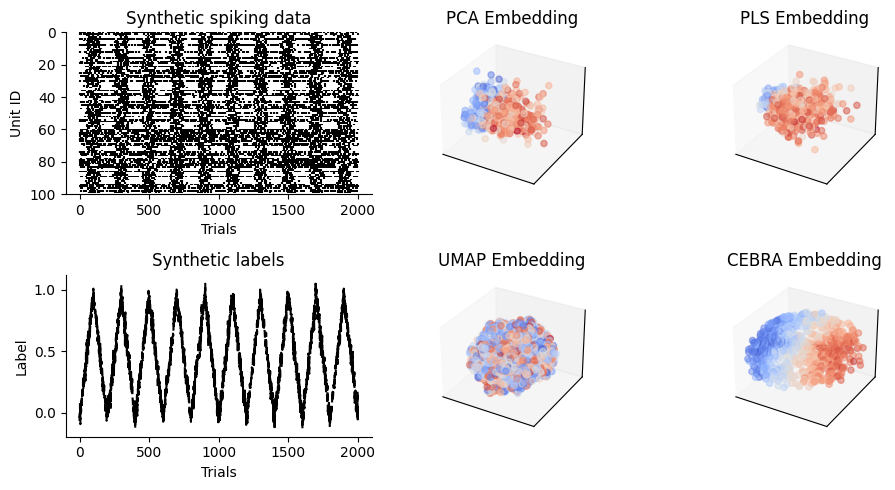

In [37]:
# Assuming the following variables are defined in your environment:
# neural_inputs (X), label_inputs, embeddings (X_pca, X_umap, X_lda, X_cebra), y_train,
# mean_accuracies, sem_accuracies, modulation_factor

neural_inputs = X
label_inputs = Y


# Plot configuration
fig = plt.figure(figsize=(15, 5))  # Increased figure size for better layout
grid = plt.GridSpec(4, 4, figure=fig)  # Adjusted GridSpec for 8 rows

# First column, two plots
ax1 = plt.subplot(grid[0:2, 0])  # Filled with the spiking data subplot
for i in range(neural_inputs.shape[1]):
    spike_times = np.where(neural_inputs[:, i] > 0)[0]
    ax1.eventplot(spike_times, lineoffsets=i, colors='black')
ax1.set_ylabel('Unit ID')
ax1.set_xlabel('Trials')
ax1.set_title('Synthetic spiking data')
ax1.set_ylim(neural_inputs.shape[1], 0)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

ax2 = plt.subplot(grid[2:4, 0])
ax2.plot(label_inputs, color='black', linestyle='--')
ax2.set_ylabel('Label')
ax2.set_xlabel('Trials')
ax2.set_title('Synthetic labels')
# ax2.set_ylim(1, 0)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

# Second column, four 3D plots for embeddings
# Removing the ticks for all axes of the 2nd column plots
axes_3d = []
axes_3d.append(plt.subplot(grid[0:2, 1], projection='3d'))
axes_3d.append(plt.subplot(grid[2:4, 1], projection='3d'))
axes_3d.append(plt.subplot(grid[0:2, 2], projection='3d'))
axes_3d.append(plt.subplot(grid[2:4, 2], projection='3d'))

embeddings = [X_pca, X_umap, X_pls, X_cebra]
titles = ['PCA Embedding', 'UMAP Embedding', 'PLS Embedding', 'CEBRA Embedding']

for ax, emb, title in zip(axes_3d, embeddings, titles):
    ax.scatter(emb[:, 0], emb[:, 1], emb[:, 2], c=y_train, cmap='coolwarm', alpha=0.5)
    ax.set_title(title)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])

plt.tight_layout(rect=[0, 0, 0.85, 1]) 
plt.show()

# Save the figure in high resolution
fig.savefig('toy_modulation_continuous.png', dpi=300)
